# TSMixer: Training

- load best parameters from hyperparameter tuning
- load data and prepare for training
- fit and save model

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

# Load best model

In [5]:
params = get_best_parameters('realtime-tsmixer-expanding-window', 'tsmixer', 'WIS_2023')

WIS_2023 of best run: 337.66157124255955


In [6]:
params

{'model': 'tsmixer',
 'dropout': 0.2,
 'ff_size': 32,
 'n_epochs': 1000,
 'norm_type': 'TimeBatchNorm2d',
 'optimizer': 'AdamW',
 'activation': 'ReLU',
 'batch_size': 32,
 'num_blocks': 8,
 'hidden_size': 32,
 'use_encoders': True,
 'use_features': False,
 'use_covariates': False,
 'normalize_before': False,
 'optimizer_kwargs': {'lr': 0.01, 'weight_decay': 0.01},
 'input_chunk_length': 8,
 'use_static_covariates': False}

In [7]:
name = params.pop('model')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
optimizer = params.pop('optimizer')

params['optimizer_cls'] = OPTIMIZER_DICT[optimizer]

In [8]:
model = TSMixerModel(
    **params,
    add_encoders=ENCODERS if use_encoders else None,
    **SHARED_ARGS
)

# Load data

In [9]:
targets, covariates = load_realtime_training_data()

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


In [10]:
targets = targets[:-4] # only use complete data points for training

<Axes: xlabel='date'>

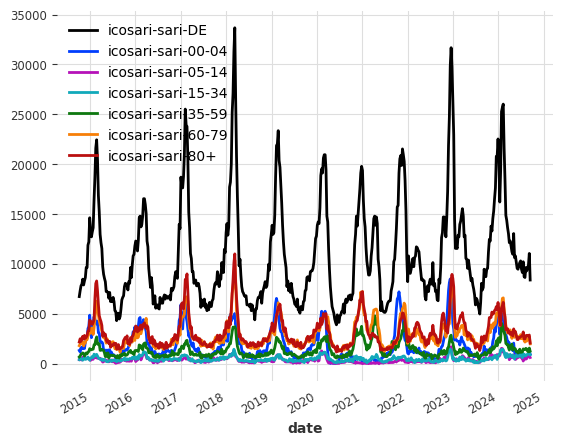

In [11]:
targets.plot()

<Axes: xlabel='date'>

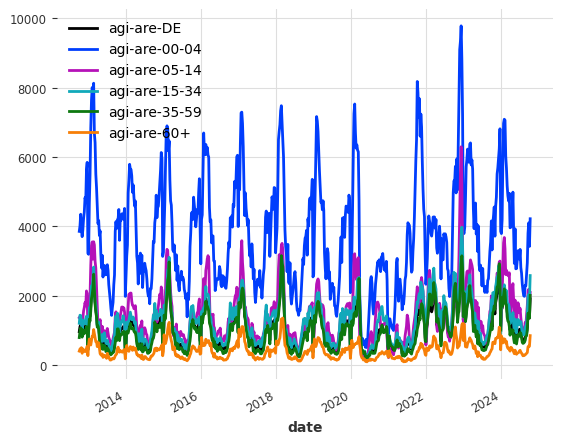

In [12]:
covariates.plot()

### Current forecast date

In [13]:
current_date = pd.Timestamp.now().date()
forecast_date = get_preceding_thursday(current_date)
forecast_date = str(forecast_date.date())
forecast_date

'2024-10-17'

# Train model

In [14]:
RANDOM_SEEDS = [1, 2, 3, 4, 5 , 6, 7, 8, 9, 10]

In [15]:
path = f'../models/realtime/{forecast_date}/'

In [16]:
os.makedirs(path, exist_ok=True)

In [ ]:
for seed in RANDOM_SEEDS:
    model_path = path + f'{forecast_date}-tsmixer-{seed}.pt'
    print(model_path)
    model.reset_model()
    model.model_params['random_state'] = seed
    model.fit(targets, past_covariates=covariates if use_covariates else None)
    model.save(model_path)

Epoch 324/999 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 14/16 0:00:00 • 0:00:01 23.47it/s train_loss: 7.521